# WEFE User guide


The following guide is designed to present the more general details on
using the package to perform measurements and bias mitigation. 

In the first section of bias measurement:

-  We first present how to run a simple query using some embedding
   model.
-  We then show how to run multiple queries on multiple embeddings.
-  After that, we show how to compare the results obtained from running
   multiple sets of queries on multiple embeddings using different
   metrics through ranking calculation.
-  Finally, we show how to calculate the correlations between the
   rankings obtained.

In the second section of bias mitigation: 

- We present the interface to reduce bias in a embedding model through two different methods.


  
**Disclaimer**

To accurately study the biases contained in word embeddings, queries may contain words that could be offensive to certain groups or individuals. The relationships studied between these words DO NOT represent the ideas, thoughts or beliefs of the authors of this library. This applies to this and all pages of the documentation.


**Note**

If you are not familiar with the concepts of query, target and attribute sets, please visit the [the framework section](https://wefe.readthedocs.io/en/latest/about.html#the-framework) on the library’s about page. These concepts will be widely used in the following sections.
  

The original guide is located in the [WEFE User Guide](https://wefe.readthedocs.io/en/latest/user_guide.html) page.

---

## Bias Measurement

### Run a Query

The following code explains how to run a gender query using [Glove](https://nlp.stanford.edu/projects/glove/). embeddings and the Word Embedding Association Test (`WEAT`) as fairness metric.
`WEAT` allows quantifying the relationship between two sets of target words and two sets of attribute words. The closer its value is to 0, the less biased the model will be.

Below we show the three usual steps for performing a query in `WEFE`:

### Load a word embeddings model as a `WordEmbedding` object.

Load the word embedding model and then wrap it using a `WordEmbeddingModel` (class that allows WEFE to handle the models). 


WEFE bases all its operations on word embeddings using Gensim's `KeyedVectors` interface. Any model that can be loaded using `KeyedVectors` will be compatible with WEFE. 

The following example uses a 25-dim pre-trained `Glove` model using a twitter dataset loaded using [`gensim-data`](https://github.com/RaRe-Technologies/gensim-data).

In [1]:
import gensim.downloader as api

from wefe.datasets import load_weat
from wefe.metrics import WEAT
from wefe.query import Query
from wefe.word_embedding_model import WordEmbeddingModel

twitter_25 = api.load("glove-twitter-25")
# WordEmbeddingModel receives as first argument a KeyedVectors model
# and the second argument the model name.
model = WordEmbeddingModel(twitter_25, "glove twitter dim=25")

INFO:gensim.models.utils_any2vec:loading projection weights from /home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz
DEBUG:smart_open.smart_open_lib:{'uri': '/home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
INFO:gensim.models.utils_any2vec:loaded (1193514, 25) matrix from /home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz


### Create the query using a `Query` object

Define the target and attribute words sets and create a Query object that contains them.

For this initial example, a query is used to study the association between gender with respect to family and career. The words used are taken from the set of words used in the *Semantics derived automatically from language corpora contain human-like biases* paper, which are included in the `datasets` module.

In [42]:
gender_query = Query(
    target_sets=[
        ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter"],
        ["male", "man", "boy", "brother", "he", "him", "his", "son"],
    ],
    attribute_sets=[
        [
            "home",
            "parents",
            "children",
            "family",
            "cousins",
            "marriage",
            "wedding",
            "relatives",
        ],
        [
            "executive",
            "management",
            "professional",
            "corporation",
            "salary",
            "office",
            "business",
            "career",
        ],
    ],
    target_sets_names=["Female terms", "Male Terms"],
    attribute_sets_names=["Family", "Careers"],
)

### Run the Query

Instantiate the metric that you will use and then execute `run_query` with the parameters created in the previous steps.

Any bias measurement process at WEFE consists of the following steps:

1. Metric arguments checking.
2. Transform the word sets into word embeddings.
3. Calculate the metric.

In this case we are going to use the `WEAT` metric (proposed in the same paper of the set of words used in the query).

In [43]:
metric = WEAT()
result = metric.run_query(gender_query, model)
print(result)

{'query_name': 'Female terms and Male Terms wrt Family and Careers', 'result': 0.3165843551978469, 'weat': 0.3165843551978469, 'effect_size': 0.6779444653930398, 'p_value': nan}


By default, the results are a `dict` containing the query name (in the key `query_name`) and the calculated value of the metric in the `result` key. 
It also contains a key with the name and the value of the calculated metric (which is duplicated in the "results" key).

Depending on the metric class used, the result `dict` can also return more metrics, detailed word-by-word values or other statistics like p-values.
Also some metrics allow you to change the default value in results, which will have implications a little further down the line.


Details of all the metrics implemented, their references, parameters and examples of execution can be found at [API documentation](https://wefe.readthedocs.io/en/latest/api.html).

---

### Run Query Arguments

Each metric allows to vary the behavior of `run_query` according to different parameters.
There are parameters to customize the transformation of the sets of words to sets of embeddings, others to warn errors or modify which calculation method the metric use.

For example, `run_query` can be instructed to `return effect_size` in the `result` key by setting `return_effect_size` as `True`. Note that this parameter is only of the class `WEAT`. 

In [4]:
weat = WEAT()
result = weat.run_query(gender_query, model, return_effect_size=True)
print(result)

{'query_name': 'Female terms and Male Terms wrt Family and Careers', 'result': 0.6779444653930398, 'weat': 0.3165843551978469, 'effect_size': 0.6779444653930398, 'p_value': nan}


You can also request `run_query` to run the statistical significance calculation by setting `calculate_p_value` as `True`. This checks how many queries generated from permutations (controlled by the parameter `p_value_iterations`) of the target sets obtain values greater than those obtained by the original query.

In [5]:
weat = WEAT()
result = weat.run_query(
    gender_query, model, calculate_p_value=True, p_value_iterations=15000
)
print(result)

{'query_name': 'Female terms and Male Terms wrt Family and Careers', 'result': 0.3165843551978469, 'weat': 0.3165843551978469, 'effect_size': 0.6779444653930398, 'p_value': 0.09119392040530631}


---

### Out of Vocabulary Words

It is common in the literature to find bias tests whose tagret sets are common names of social groups.  These names are commonly cased and may contain special characters. 
There are several embedding models whose words are not cased or do not have accents or other special characters, as for example, in `Glove`.
This implies that a query with target sets composed by names executed in `Glove` (without any preprocessing of the words) could produce erroneous results because WEFE will not be able to find the names in the model vocabulary.

**Note**

Some well-known word sets are already provided by the package and can be easily loaded by the user through the `datasets` module. From here on, the tutorial will use the words defined in the study *Semantics derived automatically from language corpora contain human-like biases*, the same that proposed the WEAT metric. 

In [6]:
# load the weat word sets.
word_sets = load_weat()

# print a set of european american common names.
print(word_sets["european_american_names_5"])

['Adam', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Justin', 'Ryan', 'Andrew', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Paul', 'Jonathan', 'Peter', 'Amanda', 'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Katie', 'Betsy', 'Kristin', 'Nancy', 'Stephanie', 'Ellen', 'Lauren', 'Colleen', 'Emily', 'Megan', 'Rachel']


The following query compares European-American and African-American names with respect to pleasant and unpleasant attributes. 

**Note**

It can be indicated to `run_query` to log the words that were lost in the transformation to vectors by using the parameter `warn_not_found_words` as `True`.

In [41]:
ethnicity_query = Query(
    [word_sets["european_american_names_5"], word_sets["african_american_names_5"]],
    [word_sets["pleasant_5"], word_sets["unpleasant_5"]],
    ["European american names", "African american names"],
    ["Pleasant", "Unpleasant"],
)
result = weat.run_query(ethnicity_query, model, warn_not_found_words=True,)
print(result)

ERROR:root:At least one set of 'European american names and African american names wrt Pleasant and Unpleasant' query has proportionally fewer embeddings than allowed by the lost_vocabulary_threshold parameter (0.2). This query will return np.nan.


{'query_name': 'European american names and African american names wrt Pleasant and Unpleasant', 'result': nan, 'weat': nan, 'effect_size': nan}


**Warning**

If more than 20% of the words from any of the word sets of the query are lost during the transformation to embeddings, the result of the metric will be `np.nan`. This behavior can be changed using a float number parameter called `lost_vocabulary_threshold`.


---

### Word Preprocessors

`run_queries` allows to preprocess each word of each set through the parameter `preprocessors` (list of one or more preprocessor), which we will define below:

A `preprocessor` is a dictionary that specifies which processes are performed before searching for the embedding associated with a word.
For example, the `preprocessor` `{'lowecase': True, 'strip_accents': True}` allows you to lowercase and remove the accent from each word before searching for them in the model.
Note that an empty dictionary `{}` indicates that no preprocessing is done.

The possible options for a preprocessor are: 

- `lowercase`: `bool`. Indicates if the words are transformed to lowercase.
- `uppercase`: `bool`. Indicates if the words are transformed to uppercase.
- `titlecase`: `bool`. Indicates if the words are transformed to titlecase.
- `strip_accents`: `bool`, `{'ascii', 'unicode'}`: Specifies if the accents
                    of the words are eliminated. The stripping type can be
                    specified. True uses 'unicode' by default.
- `preprocessor`: `Callable`. It receives a function that operates on each
                word. In the case of specifying a function, it overrides
                the default preprocessor (i.e., the previous options
                stop working).          
                
A list of these preprocessor options allows to search for several variants of the words into the model. By default, in case there is more than one preprocessor in the list, the first preprocessed word found in the embeddings model will be used. This behavior can be controlled by the `strategy` parameter of `run_query`.

In the following example, we will provide a list with only one preprocessor that instructs `run_query` to lowercase and remove all accents from every word before they are searched in the embeddings model.

In [9]:
weat = WEAT()
result = weat.run_query(
    ethnicity_query,
    model,
    preprocessors=[{"lowercase": True, "strip_accents": True}],
    warn_not_found_words=True,
)
print(result)

{'query_name': 'European american names and African american names wrt Pleasant and Unpleasant', 'result': 3.752915130034089, 'weat': 3.752915130034089, 'effect_size': 1.2746819501134965, 'p_value': nan}


It may happen that it is more important to find the original word and in the case of not finding it, then preprocess it and look it up in the vocabulary.
This behavior can be specified in `preprocessors` list by first specifying an empty preprocessor `{}` and then the preprocessor that converts to lowercase and removes accents.

In [10]:
weat = WEAT()
result = weat.run_query(
    ethnicity_query,
    model,
    preprocessors=[
        {},  # empty preprocessor, search for the original words.
        {
            "lowercase": True,
            "strip_accents": True,
        },  # search for lowercase and no accent words.
    ],
    warn_not_found_words=True,
)

print(result)

{'query_name': 'European american names and African american names wrt Pleasant and Unpleasant', 'result': 3.752915130034089, 'weat': 3.752915130034089, 'effect_size': 1.2746819501134965, 'p_value': nan}


The number of preprocessing steps can be increased as needed. For example, we can complex the above preprocessor to first search for the original words, then for the lowercase words, and finally for the lowercase words without accents.

In [11]:
weat = WEAT()
result = weat.run_query(
    ethnicity_query,
    model,
    preprocessors=[
        {},  # first step: empty preprocessor, search for the original words.
        {"lowercase": True,},  # second step: search for lowercase.
        {
            "lowercase": True,
            "strip_accents": True,
        },  # third step: search for lowercase and no accent words.
    ],
    warn_not_found_words=True,
)

print(result)

{'query_name': 'European american names and African american names wrt Pleasant and Unpleasant', 'result': 3.752915130034089, 'weat': 3.752915130034089, 'effect_size': 1.2746819501134965, 'p_value': nan}


It is also possible to change the behavior of the search by including not only the first word, but all the words generated by the preprocessors. This can be controlled by specifying the parameter `strategy=all`.

In [12]:
weat = WEAT()
result = weat.run_query(
    ethnicity_query,
    model,
    preprocessors=[
        {},  # first step: empty preprocessor, search for the original words.
        {"lowercase": True,},  # second step: search for lowercase .
        {"uppercase": True,},  # third step: search for uppercase.
    ],
    strategy="all",
    warn_not_found_words=True,
)

print(result)

{'query_name': 'European american names and African american names wrt Pleasant and Unpleasant', 'result': 3.752915130034089, 'weat': 3.752915130034089, 'effect_size': 1.2746819501134965, 'p_value': nan}


## Running multiple Queries

It is usual to want to test many queries of some bias criterion (gender, ethnicity, religion, politics, socioeconomic, among others) on several models at the same time.  Trying to use `run_query` on each pair embedding-query can be a bit complex and will require extra work to implement.

This is why the library also implements a function to test multiple queries on various word embedding models in a single call: the `run_queries` util.

The following code shows how to run various gender queries on `Glove` embedding models with different dimensions trained from the Twitter dataset. The queries are executed using `WEAT` metric.

In [13]:
import gensim.downloader as api

from wefe.datasets import load_weat
from wefe.metrics import RNSB, WEAT
from wefe.query import Query
from wefe.utils import run_queries
from wefe.word_embedding_model import WordEmbeddingModel

### Load the models:

Load three different Glove Twitter embedding models. These models were trained using the same dataset varying the number of embedding dimensions.

In [14]:
model_1 = WordEmbeddingModel(api.load("glove-twitter-25"), "glove twitter dim=25")
model_2 = WordEmbeddingModel(api.load("glove-twitter-50"), "glove twitter dim=50")
model_3 = WordEmbeddingModel(api.load("glove-twitter-100"), "glove twitter dim=100")

models = [model_1, model_2, model_3]

INFO:gensim.models.utils_any2vec:loading projection weights from /home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz
DEBUG:smart_open.smart_open_lib:{'uri': '/home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
INFO:gensim.models.utils_any2vec:loaded (1193514, 25) matrix from /home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz
INFO:gensim.models.utils_any2vec:loading projection weights from /home/pablo/gensim-data/glove-twitter-50/glove-twitter-50.gz
DEBUG:smart_open.smart_open_lib:{'uri': '/home/pablo/gensim-data/glove-twitter-50/glove-twitter-50.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
INFO:gensim.models.utils_any2vec:loaded (119351

### Load the word sets and create the queries

Now, we will load the `WEAT` word set and create three queries. The three queries are intended to measure gender bias.

In [15]:
# Load the WEAT word sets
word_sets = load_weat()

# Create gender queries
gender_query_1 = Query(
    [word_sets["male_terms"], word_sets["female_terms"]],
    [word_sets["career"], word_sets["family"]],
    ["Male terms", "Female terms"],
    ["Career", "Family"],
)

gender_query_2 = Query(
    [word_sets["male_terms"], word_sets["female_terms"]],
    [word_sets["science"], word_sets["arts"]],
    ["Male terms", "Female terms"],
    ["Science", "Arts"],
)

gender_query_3 = Query(
    [word_sets["male_terms"], word_sets["female_terms"]],
    [word_sets["math"], word_sets["arts_2"]],
    ["Male terms", "Female terms"],
    ["Math", "Arts"],
)

gender_queries = [gender_query_1, gender_query_2, gender_query_3]

### Run the queries on all Word Embeddings using WEAT.

To run our list of queries and models, we call `run_queries` using the parameters defined in the previous step. The mandatory parameters of the function are 3:

- a metric,
- a list of queries, and,
- a list of embedding models.

It is also possible to provide a name for the criterion studied in this set of queries through the parameter `queries_set_name`.  

In [16]:
# Run the queries
WEAT_gender_results = run_queries(
    WEAT, gender_queries, models, queries_set_name="Gender Queries"
)
WEAT_gender_results

ERROR:root:At least one set of 'Male terms and Female terms wrt Science and Arts' query has proportionally fewer embeddings than allowed by the lost_vocabulary_threshold parameter (0.2). This query will return np.nan.
ERROR:root:At least one set of 'Male terms and Female terms wrt Science and Arts' query has proportionally fewer embeddings than allowed by the lost_vocabulary_threshold parameter (0.2). This query will return np.nan.
ERROR:root:At least one set of 'Male terms and Female terms wrt Science and Arts' query has proportionally fewer embeddings than allowed by the lost_vocabulary_threshold parameter (0.2). This query will return np.nan.


query_name,Male terms and Female terms wrt Career and Family,Male terms and Female terms wrt Science and Arts,Male terms and Female terms wrt Math and Arts
model_name,,,
glove twitter dim=25,0.316584,NaN,-0.022133
glove twitter dim=50,0.363743,NaN,-0.272334
glove twitter dim=100,0.385351,NaN,-0.082543


### Setting metric params 

There is a whole column that has no results. As the warnings point out, when transforming the words of the sets into embeddings, there is a loss of words that is greater than the allowed by the parameter `lost_vocabulary_threshold`. In this case, it would be very useful to use the word preprocessors seen above.

`run_queries`, accept specific parameters for each metric. These extra parameters for the metric can be passed through `metric_params` parameter.
In this case, a `preprocessor` is provided to lowercase the words before searching for them in the models' vocabularies.

In [49]:
WEAT_gender_results = run_queries(
    WEAT,
    gender_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}]},
    queries_set_name="Gender Queries",
)

WEAT_gender_results

query_name,Male terms and Female terms wrt Career and Family,Male terms and Female terms wrt Science and Arts,Male terms and Female terms wrt Math and Arts
model_name,,,
glove twitter dim=25,0.316584,0.167431,-0.033912
glove twitter dim=50,0.363743,-0.084690,-0.307589
glove twitter dim=100,0.385351,0.099632,-0.155790


No query was null in these results.

### Plot the results in a barplot

The library also provides an easy way to plot the results obtained from a `run_queries` execution into a `plotly` braplot.

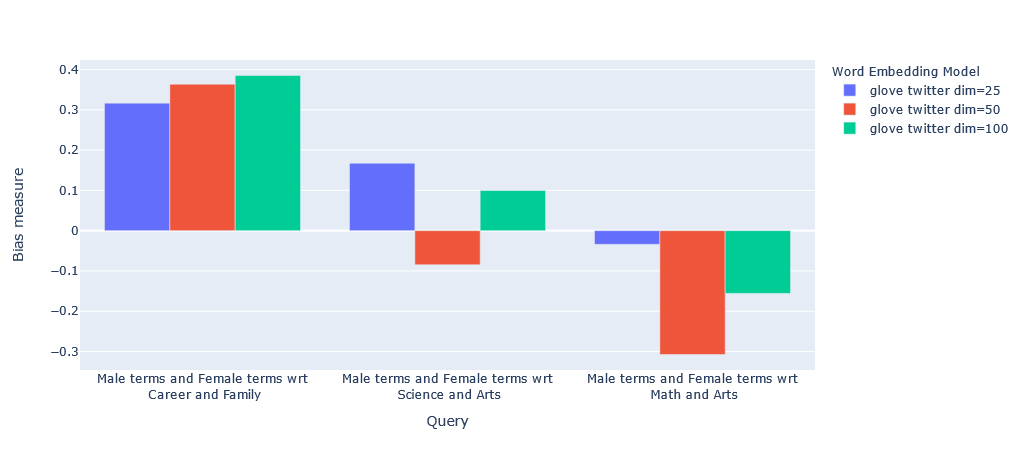

In [45]:
from wefe.utils import plot_queries_results, run_queries

# Plot the results
plot_queries_results(WEAT_gender_results).show()

### Aggregating Results

The execution of `run_queries` provided many results evaluating the gender bias in the tested embeddings. However, these results alone do not comprehensively report the biases observed in all of these queries.
One way to obtain an overall view of bias is by aggregating results by model.

For WEAT, a simple way to aggregate the results is to average their absolute values.
When running `run_queries`, it is possible to specify that the results be aggregated by model by setting `aggregate_results` as `True`


The aggregation function can be especified through the `aggregation_function` parameter. 
This parameter accepts a list of predefined aggregations as well as a custom function that operates on the results dataframe. The aggregation functions available are:

- Average `avg`.
- Average of the absolute values `abs_avg`.
- Sum `sum`.
- Sum of the absolute values, `abs_sum`.

**Note**

Notice that some functions are more appropriate for certain metrics. For metrics returning only positive numbers, all the previous aggregation functions would be OK. In contrast, metrics that returns real values (e.g., `WEAT`, `RND`, etc...), aggregation functions such as sum would make positive and negative outputs to cancel each other.



In [59]:
WEAT_gender_results_agg = run_queries(
    WEAT,
    gender_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}]},
    aggregate_results=True,
    aggregation_function="abs_avg",
    queries_set_name="Gender Queries",
)
WEAT_gender_results_agg

,Male terms and Female terms wrt Career and Family,Male terms and Female terms wrt Science and Arts,Male terms and Female terms wrt Math and Arts,WEAT: Gender Queries average of abs values score
model_name,,,,
glove twitter dim=25,0.316584,0.167431,-0.033912,0.172642
glove twitter dim=50,0.363743,-0.084690,-0.307589,0.252007
glove twitter dim=100,0.385351,0.099632,-0.155790,0.213591


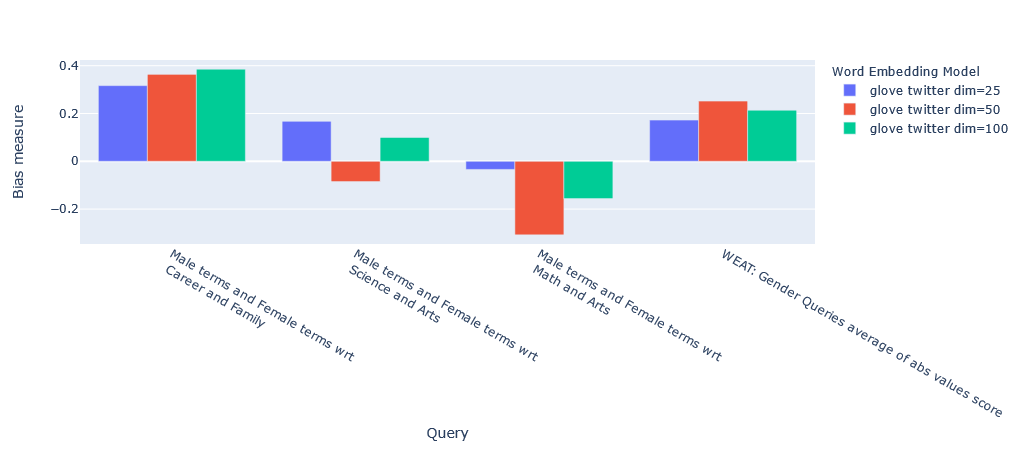

In [60]:
plot_queries_results(WEAT_gender_results_agg).show()

It is also possible to ask the function to return only the aggregated results using the parameter `return_only_aggregation`

In [61]:
WEAT_gender_results_only_agg = run_queries(
    WEAT,
    gender_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}]},
    aggregate_results=True,
    aggregation_function="abs_avg",
    return_only_aggregation=True,
    queries_set_name="Gender Queries",
)
WEAT_gender_results_only_agg

,WEAT: Gender Queries average of abs values score
model_name,
glove twitter dim=25,0.172642
glove twitter dim=50,0.252007
glove twitter dim=100,0.213591


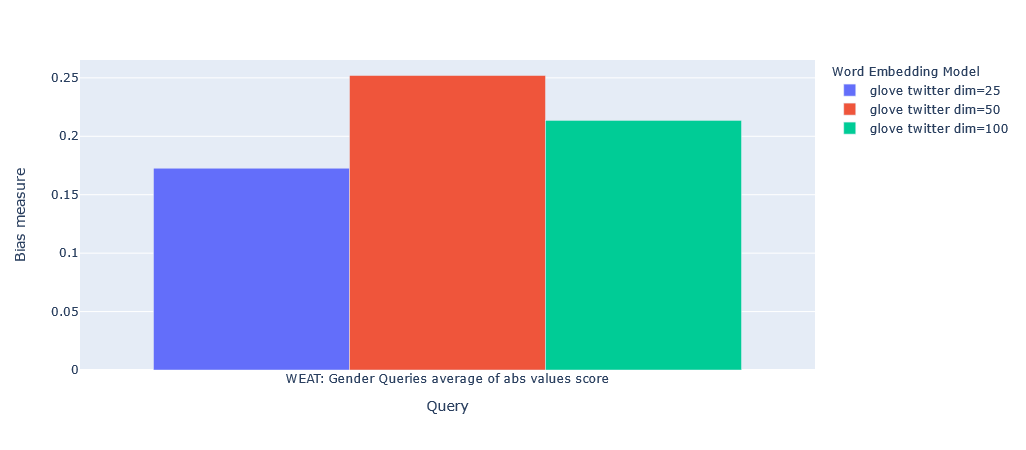

In [81]:
fig = plot_queries_results(WEAT_gender_results_only_agg)
fig.show()

## Model Bias Ranking

It may be desirable to obtain an overall view of the bias by model using different metrics or bias criteria.
While the aggregate values can be compared directly, two problems are likely to be encountered:

1. One type of bias criterion can dominate the other because of significant differences in magnitude.

2. Different metrics can operate on different scales, which makes them difficult to compare.

To show these problems, suppose:

- We have two sets of queries: one that explores gender biases and another that explores ethnicity biases. 
- 3 `Glove` models of 25, 50 and 100 dimensions trained on the same twitter dataset.

Then we run `run_queries` on this set of model-queries using WEAT, and to corroborate the results obtained, we also use Relative Negative Sentiment Bias (RNSB).

1. The first problem occurs when the bias scores obtained from one set of queries are much higher than those from the other set, even when the same metric is used.

When executing `run_queries` with the gender and ethnicity queries on the models described above, the results obtained are as follows:

<table>
<thead>
<tr class="header">
<th>model_name</th>
<th>WEAT: Gender Queries average of abs values score</th>
<th>WEAT: Ethnicity Queries average of abs values score</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>glove twitter dim=25</td>
<td><blockquote>
<p>0.210556</p>
</blockquote></td>
<td><blockquote>
<p>2.64632</p>
</blockquote></td>
</tr>
<tr class="even">
<td>glove twitter dim=50</td>
<td><blockquote>
<p>0.292373</p>
</blockquote></td>
<td><blockquote>
<p>1.87431</p>
</blockquote></td>
</tr>
<tr class="odd">
<td>glove twitter dim=100</td>
<td><blockquote>
<p>0.225116</p>
</blockquote></td>
<td><blockquote>
<p>1.78469</p>
</blockquote></td>
</tr>
</tbody>
</table>

As can be seen, the results of ethnicity bias are much greater than those of gender.

2. The second problem is when different metrics return results on different scales of magnitude.


When executing `run_queries` with the gender queries and models described above using both WEAT and RNSB, the results obtained are as follows:

<table>
<thead>
<tr class="header">
<th>model_name</th>
<th>WEAT: Gender Queries average of abs values score</th>
<th>RNSB: Gender Queries average of abs values score</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>glove twitter dim=25</td>
<td><blockquote>
<p>0.210556</p>
</blockquote></td>
<td><blockquote>
<p>0.032673</p>
</blockquote></td>
</tr>
<tr class="even">
<td>glove twitter dim=50</td>
<td><blockquote>
<p>0.292373</p>
</blockquote></td>
<td><blockquote>
<p>0.049429</p>
</blockquote></td>
</tr>
<tr class="odd">
<td>glove twitter dim=100</td>
<td><blockquote>
<p>0.225116</p>
</blockquote></td>
<td><blockquote>
<p>0.0312772</p>
</blockquote></td>
</tr>
</tbody>
</table>

We can see differences between the results of both metrics of an order of magnitude.

One solution to this problem is to create rankings. Rankings allow to focus on the relative differences reported by the metrics (for different models) instead of focusing on the absolute values.

The following guide will show how to create rankings that evaluate gender bias and ethnicity.

In [64]:
import gensim.downloader as api

from wefe.datasets.datasets import load_weat
from wefe.metrics import RNSB, WEAT
from wefe.query import Query
from wefe.utils import (
    create_ranking,
    plot_ranking,
    plot_ranking_correlations,
    run_queries,
)
from wefe.word_embedding_model import WordEmbeddingModel

# Load the models
model_1 = WordEmbeddingModel(api.load("glove-twitter-25"), "glove twitter dim=25")
model_2 = WordEmbeddingModel(api.load("glove-twitter-50"), "glove twitter dim=50")
model_3 = WordEmbeddingModel(api.load("glove-twitter-100"), "glove twitter dim=100")

models = [model_1, model_2, model_3]

# WEAT word sets
word_sets = load_weat()

INFO:gensim.models.utils_any2vec:loading projection weights from /home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz
DEBUG:smart_open.smart_open_lib:{'uri': '/home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
INFO:gensim.models.utils_any2vec:loaded (1193514, 25) matrix from /home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz
INFO:gensim.models.utils_any2vec:loading projection weights from /home/pablo/gensim-data/glove-twitter-50/glove-twitter-50.gz
DEBUG:smart_open.smart_open_lib:{'uri': '/home/pablo/gensim-data/glove-twitter-50/glove-twitter-50.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
INFO:gensim.models.utils_any2vec:loaded (119351

In [65]:
# --------------------------------------------------------------------------------
# Gender ranking

# define the queries
gender_query_1 = Query(
    [word_sets["male_terms"], word_sets["female_terms"]],
    [word_sets["career"], word_sets["family"]],
    ["Male terms", "Female terms"],
    ["Career", "Family"],
)
gender_query_2 = Query(
    [word_sets["male_terms"], word_sets["female_terms"]],
    [word_sets["science"], word_sets["arts"]],
    ["Male terms", "Female terms"],
    ["Science", "Arts"],
)
gender_query_3 = Query(
    [word_sets["male_terms"], word_sets["female_terms"]],
    [word_sets["math"], word_sets["arts_2"]],
    ["Male terms", "Female terms"],
    ["Math", "Arts"],
)

gender_queries = [gender_query_1, gender_query_2, gender_query_3]

# run the queries using WEAT
WEAT_gender_results = run_queries(
    WEAT,
    gender_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}]},
    aggregate_results=True,
    return_only_aggregation=True,
    queries_set_name="Gender Queries",
)

# run the queries using WEAT effect size
WEAT_EZ_gender_results = run_queries(
    WEAT,
    gender_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}], "return_effect_size": True,},
    aggregate_results=True,
    return_only_aggregation=True,
    queries_set_name="Gender Queries",
)

# run the queries using RNSB
RNSB_gender_results = run_queries(
    RNSB,
    gender_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}]},
    aggregate_results=True,
    return_only_aggregation=True,
    queries_set_name="Gender Queries",
)

The rankings can be calculated by means of the `create_ranking` function. This function receives as input results from running `run_queries` and assumes that the last column contains the aggregated values.

In [92]:
from wefe.utils import create_ranking

# create the ranking
gender_ranking = create_ranking(
    [WEAT_gender_results, WEAT_EZ_gender_results, RNSB_gender_results]
)

gender_ranking

,WEAT: Gender Queries average of abs values score (1),WEAT: Gender Queries average of abs values score (2),RNSB: Gender Queries average of abs values score
model_name,,,
glove twitter dim=25,1.0,1.0,3.0
glove twitter dim=50,3.0,2.0,2.0
glove twitter dim=100,2.0,3.0,1.0


In [ ]:
# --------------------------------------------------------------------------------
# Ethnicity ranking

# define the queries
ethnicity_query_1 = Query(
    [word_sets["european_american_names_5"], word_sets["african_american_names_5"]],
    [word_sets["pleasant_5"], word_sets["unpleasant_5"]],
    ["European Names", "African Names"],
    ["Pleasant", "Unpleasant"],
)

ethnicity_query_2 = Query(
    [word_sets["european_american_names_7"], word_sets["african_american_names_7"]],
    [word_sets["pleasant_9"], word_sets["unpleasant_9"]],
    ["European Names", "African Names"],
    ["Pleasant 2", "Unpleasant 2"],
)

ethnicity_queries = [ethnicity_query_1, ethnicity_query_2]

# run the queries using WEAT
WEAT_ethnicity_results = run_queries(
    WEAT,
    ethnicity_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}]},
    aggregate_results=True,
    return_only_aggregation=True,
    queries_set_name="Ethnicity Queries",
)

# run the queries using WEAT effect size
WEAT_EZ_ethnicity_results = run_queries(
    WEAT,
    ethnicity_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}], "return_effect_size": True,},
    aggregate_results=True,
    return_only_aggregation=True,
    queries_set_name="Ethnicity Queries",
)

# run the queries using RNSB
RNSB_ethnicity_results = run_queries(
    RNSB,
    ethnicity_queries,
    models,
    metric_params={"preprocessors": [{"lowercase": True}]},
    aggregate_results=True,
    return_only_aggregation=True,
    queries_set_name="Ethnicity Queries",
)

In [91]:
# create the ranking
ethnicity_ranking = create_ranking(
    [WEAT_ethnicity_results, WEAT_EZ_gender_results, RNSB_ethnicity_results]
)

ethnicity_ranking

,WEAT: Ethnicity Queries average of abs values score,WEAT: Gender Queries average of abs values score,RNSB: Ethnicity Queries average of abs values score
model_name,,,
glove twitter dim=25,3.0,1.0,3.0
glove twitter dim=50,2.0,2.0,1.0
glove twitter dim=100,1.0,3.0,2.0


### Plotting the rankings

It is possible to graph the rankings in barplots using the `plot_ranking` function.
The generated figure shows the accumulated rankings for each embedding model. Each bar represents the sum of the rankings obtained by each embedding. Each color within a bar represents a different criterion-metric ranking.

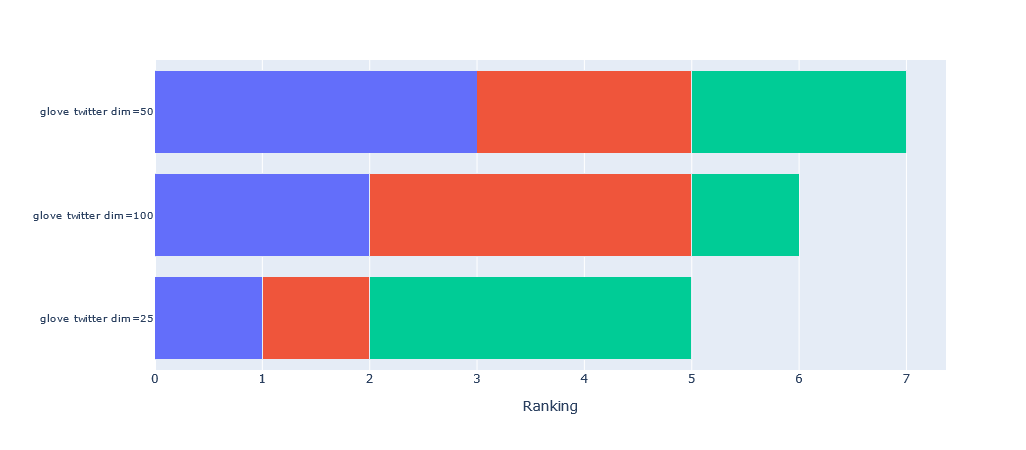

In [87]:
from wefe.utils import plot_ranking

fig = plot_ranking(gender_ranking)
fig.show()

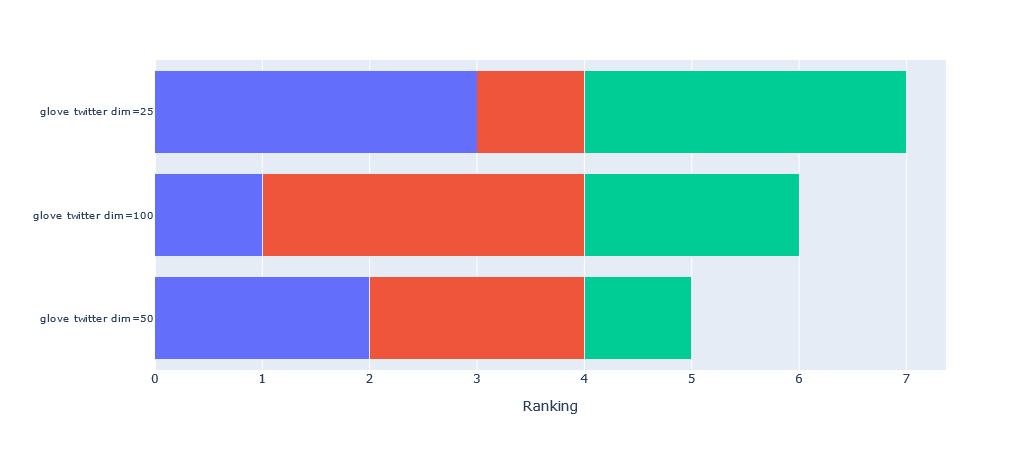

In [90]:
fig = plot_ranking(ethnicity_ranking)
fig.show()

## Ranking Correlations

Having obtained rankings by metric for each embeddings, it would be ideal to see and analyze the degree of agreement between them. 

A high concordance between rankings allows to establish with some certainty that all metrics evaluated the embedding models in a similar way. Therefore, the results obtained allow to establish an order for the embedding models.
On the other hand, a low degree of agreement shows the opposite: the rankings do not allow to clearly establish which embedding is less biased than another.


The level of concordance of the rankings can be evaluated by calculating correlations.WEFE provides `calculate_ranking_correlations` to calculate the correlations between rankings.

In [76]:
from wefe.utils import calculate_ranking_correlations, plot_ranking_correlations

correlations = calculate_ranking_correlations(gender_ranking)
correlations

,WEAT: Gender Queries average of abs values score (1),WEAT: Gender Queries average of abs values score (2),RNSB: Gender Queries average of abs values score
WEAT: Gender Queries average of abs values score (1),1.0,0.5,-0.5
WEAT: Gender Queries average of abs values score (2),0.5,1.0,-1.0
RNSB: Gender Queries average of abs values score,-0.5,-1.0,1.0


**Note**

`calculate_ranking_correlations` uses the `corr()` `pandas` dataframe method. 
It is allowed to provide the method parameter that allows to change the type of correlation calculated. The options are: `'pearson'`, `'spearman'`, `'kendall'`. By default, the pearson correlation is calculated.

In this example, Kendall's correlation is used. 

In [77]:
calculate_ranking_correlations(gender_ranking, method="kendall")

,WEAT: Gender Queries average of abs values score (1),WEAT: Gender Queries average of abs values score (2),RNSB: Gender Queries average of abs values score
WEAT: Gender Queries average of abs values score (1),1.000000,0.333333,-0.333333
WEAT: Gender Queries average of abs values score (2),0.333333,1.000000,-1.000000
RNSB: Gender Queries average of abs values score,-0.333333,-1.000000,1.000000


WEFE also provides a function for graph the correlations:

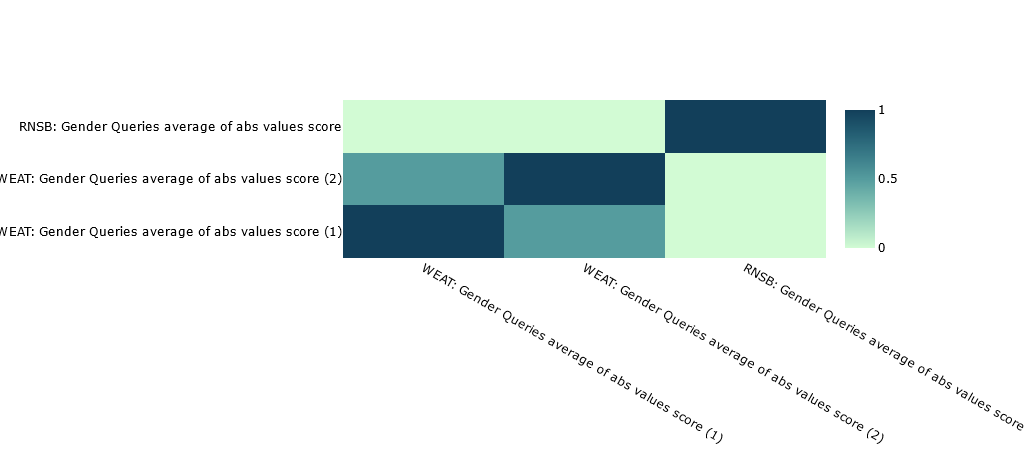

In [78]:
correlation_fig = plot_ranking_correlations(correlations)
correlation_fig.show()

In this case, only two of the three rankings show similar results.

---

## Bias Mitigation

WEFE also provides several methods to mitigate the bias of the embedding models. In the following section we explain how to use the bias mitigation module through several use cases.

In [37]:
import gensim.downloader as api

from wefe.datasets import fetch_debiaswe, load_weat
from wefe.debias.hard_debias import HardDebias
from wefe.metrics import WEAT
from wefe.query import Query
from wefe.word_embedding_model import WordEmbeddingModel

twitter_25 = api.load("glove-twitter-25")
model = WordEmbeddingModel(twitter_25, "glove-twitter-dim=25")

INFO:gensim.models.utils_any2vec:loading projection weights from /home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz
DEBUG:smart_open.smart_open_lib:{'uri': '/home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
INFO:gensim.models.utils_any2vec:loaded (1193514, 25) matrix from /home/pablo/gensim-data/glove-twitter-25/glove-twitter-25.gz


### Hard Debias


This method allows to reduce the bias of an embedding model through geometric
operations between embeddings.
This method is binary because it only allows 2 classes of the same bias criterion,
such as male or female.


The main idea of this method is:

1. **Identify a bias subspace through the defining sets.** In the case of gender, these could be e.g. `{'woman', 'man'}, {'she', 'he'}, ...`

2. **Neutralize the bias subspace on the embeddings that should not be biased.**

    First, it is defined a set of words that are correct to be related to the bias criterion: the *criterion specific gender words*. For example, in the case of gender, *gender specific* words are: `{'he', 'his', 'He', 'her', 'she', 'him', 'him', 'She', 'man', 'women', 'men'...}`.

    Then, it is defined that all words outside this set should have no relation to the
bias criterion and thus have the possibility of being biased. (e.g. for the case of
gender: `{doctor, nurse, ...}`). Therefore, this set of words is neutralized with
respect to the bias subspace found in the previous step.

    The neutralization is carried out under the following operation:

    - u : embedding
    - v : bias direction

    First calculate the projection of the embedding on the bias subspace.
    - projection = v • (v • u) / (v • v)

    Then subtract the projection from the embedding.
    - u' = u - projection


3. **Equalize the embeddings with respect to the bias direction.**. 

    Given an equalization set (set of word pairs such as [she, he], [men, women], ...,
but not limited to the definitional set) this step executes, for each pair, an equalization with respect to the bias direction.
That is, it takes a pair of embeddings and distributes them both at the same distance from the bias direction, so that neither is closer to the bias direction than the other.

### Fit-Transform Interface

WEFE implements all debias methods through an interface inspired by the transformers of `scikit-learn`. 
That is, the execution of a debias method involves two steps: 
- First a training through the `fit` method where the transformation that will be applied on the embeddings is calculated 
- Second, a `transform` that applies the trained transformation.

Each of these stages defines its own parameters. 

The fit parameters define how the neutralization will be calculated. In Hard Debias, you have to provide the the `definitional_pairs`, the `equalize_pairs` (which could be the same of definitional pairs) and optionally, a debias `criterion_name` (to name the debiased model).

In [38]:
debiaswe_wordsets = fetch_debiaswe()

definitional_pairs = debiaswe_wordsets["definitional_pairs"]
equalize_pairs = debiaswe_wordsets["equalize_pairs"]
gender_specific = debiaswe_wordsets["gender_specific"]

In [39]:
hd = HardDebias(verbose=False).fit(
    model,
    definitional_pairs=definitional_pairs,
    equalize_pairs=equalize_pairs,
    criterion_name="gender",
)

/home/pablo/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning:

Mean of empty slice.

/home/pablo/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning:

invalid value encountered in double_scalars



The parameters of the transform method are relatively standard for all methods. The most important ones are `target`, `ignore` and `copy`.

In the following example we use `ignore` and `copy`, which are described below:

- `ignore` (by default, `None`):

    A list of strings that indicates that the debias method will perform the debias in all words except those specified in this list. In case it is not specified, debias will be executed on all words.
    In case ignore is not specified or its value is None, the transformation will be performed on all embeddings. This may cause words that are specific to social groups to lose that component (for example, leaving `'she'` and `'he'` without a gender component).
    
- `copy` (by default `True`):

    if the value of copy is `True`, method attempts to create a copy of the model and run debias on the copy.
    If `False`, the method is applied on the original model, causing the vectors to mutate.
    
    **WARNING:** Setting copy with `True` requires at least 2x RAM of the size of the model. Otherwise the execution of the debias may rise `MemoryError`.

Next, the transformation is executed using a copy of the model and ignoring the words contained in `gender_specific`.

In [93]:
gender_debiased_model = hd.transform(model, ignore=gender_specific, copy=True)

Copy argument is True. Transform will attempt to create a copy of the original model. This may fail due to lack of memory.


INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


Model copy created successfully.


  0%|          | 0/1193514 [00:00<?, ?it/s]


AttributeError: 'Word2VecKeyedVectors' object has no attribute 'key_to_index'

Using the metrics displayed in the first section of this user guide, we can measure whether or not there was a change in the measured bias between the original model and the debiased model.

In [ ]:
weat_wordset = load_weat()
weat = WEAT()

gender_query_1 = Query(
    [word_sets["male_terms"], word_sets["female_terms"]],
    [word_sets["career"], word_sets["family"]],
    ["Male terms", "Female terms"],
    ["Career", "Family"],
)

gender_query_2 = Query(
    [weat_wordset["male_names"], weat_wordset["female_names"]],
    [weat_wordset["pleasant_5"], weat_wordset["unpleasant_5"]],
    ["Male Names", "Female Names"],
    ["Pleasant", "Unpleasant"],
)

In [ ]:
biased_results_1 = weat.run_query(gender_query_1, model, normalize=True)
debiased_results_1 = weat.run_query(gender_query, gender_debiased_model, normalize=True)

print(
    round(biased_results_1["weat"], 3),
    "<",
    round(debiased_results_1["weat"], 3),
    "=",
    debiased_results_1["weat"] < biased_results_1["weat"],
)

In [ ]:
biased_results_2 = weat.run_query(
    gender_query_2, model, normalize=True, preprocessors=[{}, {"lowercase": True}]
)
debiased_results_2 = weat.run_query(
    gender_query_2,
    gender_debiased_model,
    normalize=True,
    preprocessors=[{}, {"lowercase": True}],
)

print(
    round(biased_results_2["weat"], 3),
    "<",
    round(debiased_results_2["weat"], 3),
    "=",
    debiased_results_2["weat"] < biased_results_2["weat"],
)

#### Target Parameter

- target ``
    If a set of words is specified in target, the debias method will be performed
    only on the word embeddings of this set. In the case of provide `None`, the
    debias will be performed on all words (except those specified in ignore).
    by default `None`.
    
    
In this example only the words related to career and family are debiased:

```python
['executive',
 'management',
 'professional',
 'corporation',
 'salary',
 'office',
 'business',
 'career',
 'home',
 'parents',
 'children',
 'family',
 'cousins',
 'marriage',
 'wedding',
 'relatives']
```

In [95]:
hd = HardDebias(verbose=False).fit(
    model,
    definitional_pairs=definitional_pairs,
    equalize_pairs=equalize_pairs,
    criterion_name="gender",
)


gender_debiased_model = hd.transform(
    model, target=word_sets["career"] + word_sets["family"], copy=True
)

/home/pablo/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning:

Mean of empty slice.

/home/pablo/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning:

invalid value encountered in double_scalars



Copy argument is True. Transform will attempt to create a copy of the original model. This may fail due to lack of memory.


INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


Model copy created successfully.


  0%|          | 0/16 [00:00<?, ?it/s]


AttributeError: 'Word2VecKeyedVectors' object has no attribute 'key_to_index'

In [ ]:
biased_results_1 = weat.run_query(gender_query_1, model, normalize=True)
debiased_results_1 = weat.run_query(gender_query, gender_debiased_model, normalize=True)

print(
    round(biased_results_1["weat"], 3),
    "<",
    round(debiased_results_1["weat"], 3),
    "=",
    debiased_results_1["weat"] < biased_results_1["weat"],
)

In [ ]:
biased_results_2 = weat.run_query(
    gender_query_2, model, normalize=True, preprocessors=[{}, {"lowercase": True}]
)
debiased_results_2 = weat.run_query(
    gender_query_2,
    gender_debiased_model,
    normalize=True,
    preprocessors=[{}, {"lowercase": True}],
)

print(
    round(biased_results_2["weat"], 3),
    "<",
    round(debiased_results_2["weat"], 3),
    "=",
    debiased_results_2["weat"] < biased_results_2["weat"],
)

### Multiclass Hard Debias

Multiclass Hard Debias is a generalized version of Hard Debias that enables multiclass debiasing.
Generalized refers to the fact that this method extends Hard Debias in order to support more than two types of social target sets within the definitional set.

For example, for the case of religion bias, it supports a debias using words associated with Christianity, Islam and Judaism.



In [ ]:
from wefe.datasets import fetch_debias_multiclass
from wefe.debias.multiclass_hard_debias import MulticlassHardDebias

multiclass_debias_wordsets = fetch_debias_multiclass()
weat_wordsets = load_weat()
weat = WEAT()

ethnicity_definitional_sets = multiclass_debias_wordsets["ethnicity_definitional_sets"]
ethnicity_equalize_sets = list(
    multiclass_debias_wordsets["ethnicity_analogy_templates"].values()
)

mhd = MulticlassHardDebias(verbose=True)
mhd.fit(
    model=model,
    definitional_sets=ethnicity_definitional_sets,
    equalize_sets=ethnicity_equalize_sets,
    criterion_name="ethnicity",
)

ethnicity_debiased_model = mhd.transform(model, copy=True)

In [ ]:
# test with weat

ethnicity_query = Query(
    [
        weat_wordsets["european_american_names_5"],
        weat_wordsets["african_american_names_5"],
    ],
    [weat_wordsets["pleasant_5"], weat_wordsets["unpleasant_5"]],
    ["european_american_names", "african_american_names"],
    ["pleasant", "unpleasant"],
)

biased_results = weat.run_query(
    ethnicity_query, model, normalize=True, preprocessors=[{}, {"lowercase": True}],
)
debiased_results = weat.run_query(
    ethnicity_query,
    ethnicity_debiased_model,
    normalize=True,
    preprocessors=[{}, {"lowercase": True}],
)

In [ ]:
debiased_results

In [ ]:
debiased_results["weat"] < biased_results["weat"]

In [ ]:
biased_results